# 2025.1.29 Experiments

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Modify base path for depending on your file structure.
BASE_PATH = "/Users/paxton/git"

# Specify path where .pkl files are located
target_dir = f"{BASE_PATH}/quail_volcano/scenarios/simple_1D_test"
# Specify path for Quail source code
source_dir = f"{BASE_PATH}/quail_volcano/src"
# Change to working directory
os.chdir(target_dir)


# Import quail modules
os.chdir(source_dir)

import meshing.tools as mesh_tools

import numerics.helpers.helpers as helpers
import numerics.timestepping.tools as stepper_tools

import physics.zerodimensional.zerodimensional as zerod
import physics.euler.euler as euler
import physics.navierstokes.navierstokes as navierstokes
import physics.scalar.scalar as scalar
import physics.chemistry.chemistry as chemistry
import physics.multiphasevpT.multiphasevpT as multiphasevpT

import processing.readwritedatafiles as readwritedatafiles
import processing.post as post
import processing.plot as plot

import solver.DG as DG
import solver.ADERDG as ADERDG
import solver.tools as solver_tools

import time
import multiprocessing as mp  
from multidomain import Domain, Observer

os.chdir(target_dir)

In [2]:
from IPython.display import HTML
from matplotlib import animation


VISCOSITY_FRICTION_SOURCE_IDX = 0

def initial_vars(folder):
    solver = readwritedatafiles.read_data_file(f"{folder}/test_output_{0}.pkl") 
    rho = solver.state_coeffs[..., 0:3].sum(axis=-1, keepdims=True)
    pressure = solver.physics.compute_additional_variable("Pressure", solver.state_coeffs, True)  

    print(f"The density at t=0, x=0 is: {rho.ravel()[0]} while the pressure: {pressure.ravel()[0]/1e6} MPa")

def plot_pressure_vs_density(folder, frame=100):
    solver = readwritedatafiles.read_data_file(f"{folder}/test_output_{frame}.pkl") 
    rho = solver.state_coeffs[..., 0:3].sum(axis=-1, keepdims=True)
    pressure = solver.physics.compute_additional_variable("Pressure", solver.state_coeffs, True) 

    plt.plot(rho.ravel(), pressure.ravel()/1e6)
    plt.xlabel("density [kg/m^3]")
    plt.ylabel("pressure [MPa]")
    plt.show()

def animate_conduit_pressure(folder, iterations=1000):
    fig = plt.figure(figsize=(8,12))
    ax = fig.add_subplot(511,autoscale_on=False,\
                            xlim=(0,-1000),ylim=(0,3))
    ax2 = fig.add_subplot(512,autoscale_on=False,\
                            xlim=(0,-1000),ylim=(-0.5,1.5))
    ax3 = fig.add_subplot(513, autoscale_on=False,\
                            xlim=(0,-1000), ylim=(0,1200))
    ax4 = fig.add_subplot(514, autoscale_on=False,\
                            xlim=(0,-1000), ylim=(0,1))
    ax5 = fig.add_subplot(515, autoscale_on=False,\
                            xlim=(0,-1000), ylim=(-0.02,0.02)) 

    pressure_line,  = ax.plot([], [], color="blue", label="pressure")
    velocity_line, = ax2.plot([], [], color="red", label="velocity")
    sound_speed_line, = ax3.plot([], [], color="green", label="speed of sound")
    viscosity_line, = ax4.plot([], [], color="orange", label="viscosity")

    total_water_line, = ax5.plot([], [], color="purple", label="total water")
    exsolved_water_line, = ax5.plot([], [], color="blue", label="exsolved water")
    ax5.legend(loc="upper right")

    ax5.set_xlabel("Depth [m]")

    ax.set_ylabel("Pressure [MPa]")
    ax2.set_ylabel("Velocity [m/s]")
    ax3.set_ylabel("Speed of sound [m/s]")
    ax4.set_ylabel("Effective viscosity [MPa * s]")
    ax5.set_ylabel("Water partial density")

    time_template = 'time = %.2f [s]'
    time_text = ax.text(0.7,0.9,'',transform=ax.transAxes)

    pl_template = 'P_L = %2f [M Pa]'
    pl_text = ax.text(0.7, 0.8, "", transform=ax.transAxes)

    velocity_template = 'V = %2f [m/s]'
    velocity_text = ax2.text(0.7, 0.9, "", transform=ax2.transAxes)

    def init():
        pressure_line.set_data([], [])
        velocity_line.set_data([], [])
        sound_speed_line.set_data([], [])
        viscosity_line.set_data([], [])
        total_water_line.set_data([], [])
        exsolved_water_line.set_data([], [])

        time_text.set_text("")
        pl_text.set_text("")
        velocity_text.set_text("")
        return pressure_line, velocity_line, viscosity_line, total_water_line, exsolved_water_line, time_text, pl_text, velocity_text

    def animate(i):
        solver = readwritedatafiles.read_data_file(f"{folder}/test_output_{i}.pkl")
        flag_non_physical = True
        p = solver.physics.compute_additional_variable("Pressure", solver.state_coeffs, flag_non_physical)
        v = solver.physics.compute_additional_variable("Velocity", solver.state_coeffs, flag_non_physical)
        sound_speed = solver.physics.compute_additional_variable("SoundSpeed", solver.state_coeffs, flag_non_physical)

        fsource = solver.physics.source_terms[VISCOSITY_FRICTION_SOURCE_IDX]
        viscosity = fsource.compute_viscosity(solver.state_coeffs, solver.physics)

        arhoWt = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityWt")]
        arhoWv = solver.state_coeffs[:,:,1]

        # Get the position of of each nodal points (location corresponding to each entry of pDensityX)
        nodal_pts = solver.basis.get_nodes(solver.order)
        # Allocate [ne] x [nb, ndims]
        x = np.empty((solver.mesh.num_elems,) + nodal_pts.shape)
        for elem_ID in range(solver.mesh.num_elems):
            # Fill coordinates in physical space
            x[elem_ID] = mesh_tools.ref_to_phys(solver.mesh, elem_ID, nodal_pts)
        
        pressure_line.set_data(x.ravel(), p.ravel()/1e6)
        velocity_line.set_data(x.ravel(), v.ravel())
        sound_speed_line.set_data(x.ravel(), sound_speed.ravel())
        viscosity_line.set_data(x.ravel(), viscosity.ravel()/1e6)
        total_water_line.set_data(x.ravel(), arhoWt.ravel())
        exsolved_water_line.set_data(x.ravel(), arhoWv.ravel())


        time_text.set_text(time_template % solver.time)
        pl_text.set_text(pl_template % (p.ravel()/1e6)[0])
        velocity_text.set_text(velocity_template % (v.ravel())[0])

        return pressure_line, velocity_line, sound_speed_line, viscosity_line, total_water_line, exsolved_water_line, time_text, pl_text, velocity_text

    plt.close()
    return animation.FuncAnimation(fig, animate, np.arange(iterations), blit=False, init_func=init, interval=50)

## 1. Steady state flow

- No water, no air, no crystals 
- constant viscosity. 
- g = 0 

### Conservation of momentum 
$$
\rho (\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial y}) = - \frac{\partial p}{\partial y} - \rho g - \frac{2 \tau}{R}
$$

The term on the left is the inertial term, and the terms on the right are pressure gradient, weight, and drag. For the sake of our rough analytical solution, we assume that the fluid is largely incompressible and as a result, we expect the steady state of have a constant velocity with respect to both time and space. 

$$
0 = - \frac{\partial p}{\partial x} - \frac{2 \tau}{R}
$$

For laminar flows, $\tau = \frac{4 \mu u}{R}$ where $\mu$ is viscosity. For our steady state flow, pressure changes with respect to x linearly. $\frac{\partial p}{\partial t} = \frac{P_L - P_0}{L}$. Plugging those quantities into the above equation, we get. 

$$
\begin{align}
0 &= \frac{P_L - P_0}{L} - \frac{8\mu u}{R^2} \\

u &= \frac{P_L - P_0}{L} \frac{R^2}{8 \mu}
\end{align}
$$

It is worth noting that because the fluid is compressible, in reality $p = p(\rho)$ and specifically pressure increases slightly with density. However, our analytical solution above should still be approximately correct given that our fluid is not that compressible. 

In [3]:
from astropy import units as u

# the viscosity is calculated from the numerical simulation. 
mu = 4.7 * 1e5 * u.Pa * u.s
R = 50 * u.m
L = 1000 * u.m
P_0 = 0.5 * u.MPa
P_l = 0.994 * u.MPa

u_steady_state = ((P_l - P_0)/L) * (R**2 / (8*mu))

print(f"The predicted velocity of the steady state solution: {u_steady_state.to(u.m/u.s)}")

The predicted velocity of the steady state solution: 0.3284574468085106 m / s


In [7]:
# Still in the works 
HTML(animate_conduit_pressure("slip_variable_addition", 100).to_html5_video())

## Water content

$$C = \sqrt(K/\rho)$$

For numerical stability we need 

$$Lul + c <= (\Delta x / \Delta t)$$

The speed of sound decreases a lot when there is exsolved water. Now that we are reducing water content, the sound of speed of the mixture is increasing. 

$arhoWv$ - amount of exsolved water also partial density of water vapour. We model exsolved water using ideal gas laws. 

$archoWt$ - $arhoWv$ = dissolved water 

The amount of dissolved water cannot be 0. 
 
When the amount of exsolved water decreases, the sound of speed increases, and therefore we need a smaller step size. 

I was able to decrease $arhoWv = 0.001$ by increasing the number of steps for the simulation to 30,000. The downside of this approach is that it takes the simulation longer to run locally. 




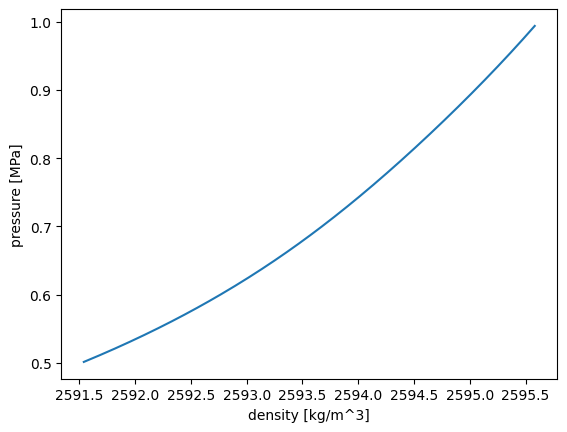

In [5]:
plot_pressure_vs_density("slip_variable_addition")